In [1]:
from dobbel import dobbellogger
from help_functies import *
from calibrator import calibrate
import matplotlib.pyplot as plt
dob = dobbellogger()

In [2]:
cali = calibrate(dob)
gyro_bias = cali['gyro bias']
acc_bias = cali['acc bias']
acc_std = cali['acc std']
gyro_std = cali['gyro std']

Leg de dobbelsteen met nummer  1  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf


In [3]:
print(cali)

{'gyro bias': array([-0.12949335,  0.48541781, -0.06450697]), 'acc bias': array([ 0.00199216,  0.02587077, -0.04644105]), 'gyro std': array([0.07407522, 0.06425244, 0.0762076 ]), 'acc std': array([0.00163541, 0.00139162, 0.00181234])}


In [14]:
dob.connect()
dob.log(10, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 10s
Done! The data is located in self.datadf


In [15]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [16]:
data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.985577,-0.049064,0.013032,0.179198,-0.119564,-0.287547
1,10.0,0.996637,-0.047233,0.012564,0.553917,0.002387,-0.847177
2,21.0,0.993967,-0.047599,0.012758,0.091120,0.002387,0.111894
3,31.0,0.993000,-0.048820,0.011818,-0.089414,-0.119564,0.044161
4,40.0,0.993492,-0.048332,0.012373,-0.003654,-0.058589,0.035148
...,...,...,...,...,...,...,...
1010,9866.0,0.995454,-0.048210,0.009564,-0.051041,0.002387,-0.003226
1011,9876.0,0.995105,-0.048088,0.010381,-0.089414,0.002387,0.044161
1012,9886.0,0.991911,-0.049308,0.012193,-0.089414,-0.058589,0.044161
1013,9897.0,0.992602,-0.049797,0.011339,0.215253,-0.058589,0.055493


In [17]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 4930.67881773399
x_acc 0.9919147020870611
y_acc -0.045790584488472987
z_acc 0.010258830406274504
x_gyro 110.88848992411307
y_gyro -0.4831327952361539
z_gyro -0.19792716691717607


In [18]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [19]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))

In [20]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11

q_list = [qtmin1tmin1]


Q = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])

R = np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

epsilon_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)

    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)

    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)

    # q0, q1, q2, q3 = quaternion_conjugate(qttmin1)
    q0, q1, q2, q3 = qttmin1    # Zou kunnen dat hier de geconjugeerde genomen moet worden!!
    H = 2 * np.array([
        [-q2, q3, -q0, q1],
        [q1, q0, q3, q2],
        [2 * q0, 0, 0, 2 * q3]
    ])
    # H = -2 * np.array([
    #     [q2, q3, q0, q1],
    #     [-q1, -q0, q3, q2],
    #     [2 * q0, 0, 0, 2 * q3]
    # ])
    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    # yattmin1 = rotate_vector(gn, qttmin1) #quaternion_conjugate(qttmin1)) # Zou kunnen dat hier een min voor moet!!! en geconjugeerde
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    yat = yat / np.linalg.norm(yat)
    epsilon = yat - yattmin1
    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    # P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, S), K.T)
    P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    # J = np.matmul(q_tt_measure, q_tt_measure.T) / (np.linalg.norm(q_tt_measure) ** 3)
    # np.matmul(np.matmul(J, P_tt_measure), J.T)
    Ptt = P_tt_measure

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)

    q_list.append(qtmin1tmin1)

    epsilon_list.append(epsilon)

In [21]:
rotvec_x = []
rotvec_y = []
rotvec_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quaternion_to_euler(q) * 180 / np.pi
    rotvec_x.append(euler[0])
    rotvec_y.append(euler[1])
    rotvec_z.append(euler[2])

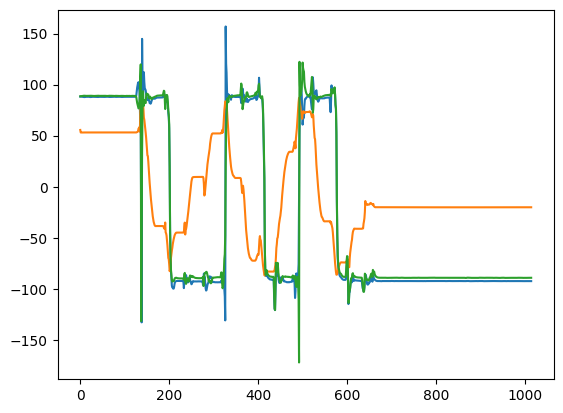

In [22]:
plt.plot(rotvec_x)
plt.plot(rotvec_y)
plt.plot(rotvec_z)

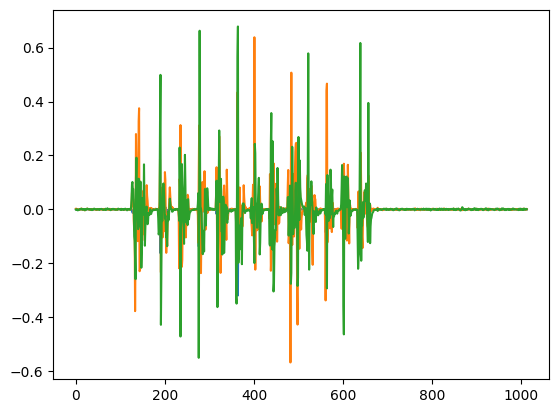

In [23]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])